# Mask R-CNN - Inspect Balloon Training Data

* 检查并可视化数据加载和预处理代码

In [2]:
import os  # 调用方法处理文件和目录
import sys # 调用模块提供对解释器使用或维护的某些变量以及与解释器强烈交互的功能的访问
import itertools # 为高效循环而创建迭代器的函数
import math # 提供对C标准定义的数学函数的访问
import logging # 定义的函数和类为应用程序和库实现了灵活的时间日志记录系统
import json # 一种受javascript对象文字语法启发的轻量级数据交换格式
import re # 提供与Perl中类似的正则表达式匹配操作
import random # 模块为各种分布实现伪随机数生成器
from collections import OrderedDict # 容器数据类型中，记住命令条目已添加的dict子类
import numpy as np # 科学计算软件包
import matplotlib # 使用Python可视化
import matplotlib.pyplot as plt # 使matplotlib像MATLAB一样工作的函数集合
import matplotlib.patches as patches # 生成图形函数集合
import matplotlib.lines as lines # 模块包含所有2D线类，可使用各种线形，标记和颜色进行绘制
from matplotlib.patches import Polygon # 绘制一个多边形

# 项目根目录  # E:\Mask_RCNN-tf2
ROOT_DIR = os.path.abspath("../../")

# 导入Mask R-CNN中的函数模块
sys.path.append(ROOT_DIR)  # 查找本地版本的库
from mrcnn import utils # 导入通用实用程序的功能与类
from mrcnn import visualize # 导入显示和可视化功能
from mrcnn.visualize import display_images # 显示给定的图像数据集的函数
import mrcnn.model as modellib # 导入mask rcnn的模型
from mrcnn.model import log # 导入日志记录函数

from samples.balloon import balloon # 导入命令执行文件夹

%matplotlib inline

## Configurations

* 配置 balloon.py 中的定义

In [3]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "samples/balloon")
print(BALLOON_DIR)
config.display()

E:\Mask_RCNN-tf2\samples/balloon

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE      

## Dataset

In [4]:
# 加载数据集
# 从发布页面获取相应的数据集
# https://github.com/matterport/Mask_RCNN/releases
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "train")

# 在使用数据集前必须先调用
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 61
Class Count: 2
  0. BG                                                
  1. balloon                                           


## Display Samples

* 加载并显示图像和mask

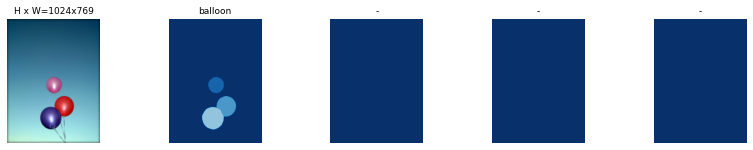

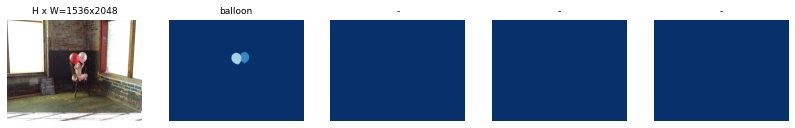

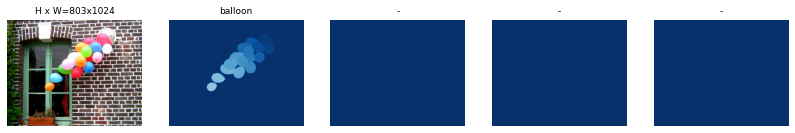

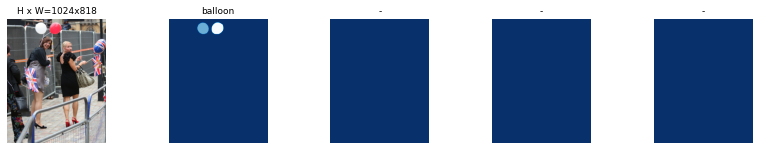

In [5]:
# 加载并显示4个随机样本
image_ids = np.random.choice(dataset.image_ids, 4)
# print(image_ids)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

* 我们不是使用源数据集提供的边界框坐标，而是从蒙版计算边界框。
* 这使我们能够始终如一地处理边界框，而不管源数据集如何，而且还使调整图像大小，旋转或裁剪图像变得更加容易，因为我们只是从更新蒙版生成边界框，而不是为每种图像类型计算边界框变换转型。

image_id  11 E:\Mask_RCNN-tf2\samples/balloon\train\14321263043_b76ef054d3_k.jpg
image                    shape: (1356, 2048, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1356, 2048, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:    1.00000  max:  845.00000  int32


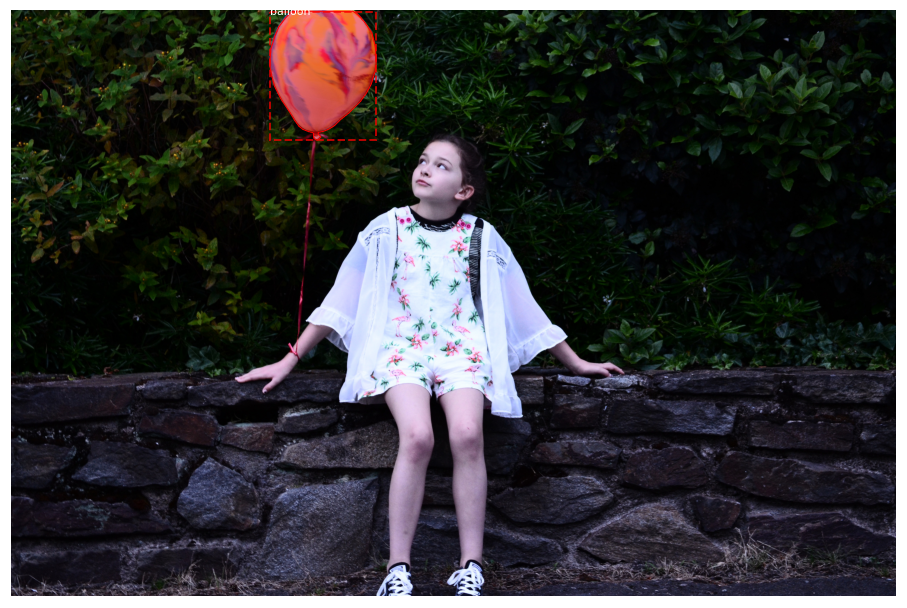

In [6]:
# 随机加载图像和 mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# 计算 Bounding box
bbox = utils.extract_bboxes(mask)

# 显示图片和其他统计信息
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# 显示图像和实例
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

* 为了每批支持多张图像，将图像调整为一种尺寸（1024x1024）。 
* 不过，长宽比会保留下来。如果图像不是正方形，则在顶部/底部或右侧/左侧添加零填充

image_id:  17 E:\Mask_RCNN-tf2\samples/balloon\train\9330497995_4cf0438cb6_k.jpg
Original shape:  (1421, 2048, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
mask                     shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (3, 4)                min:    1.00000  max:  826.00000  int32


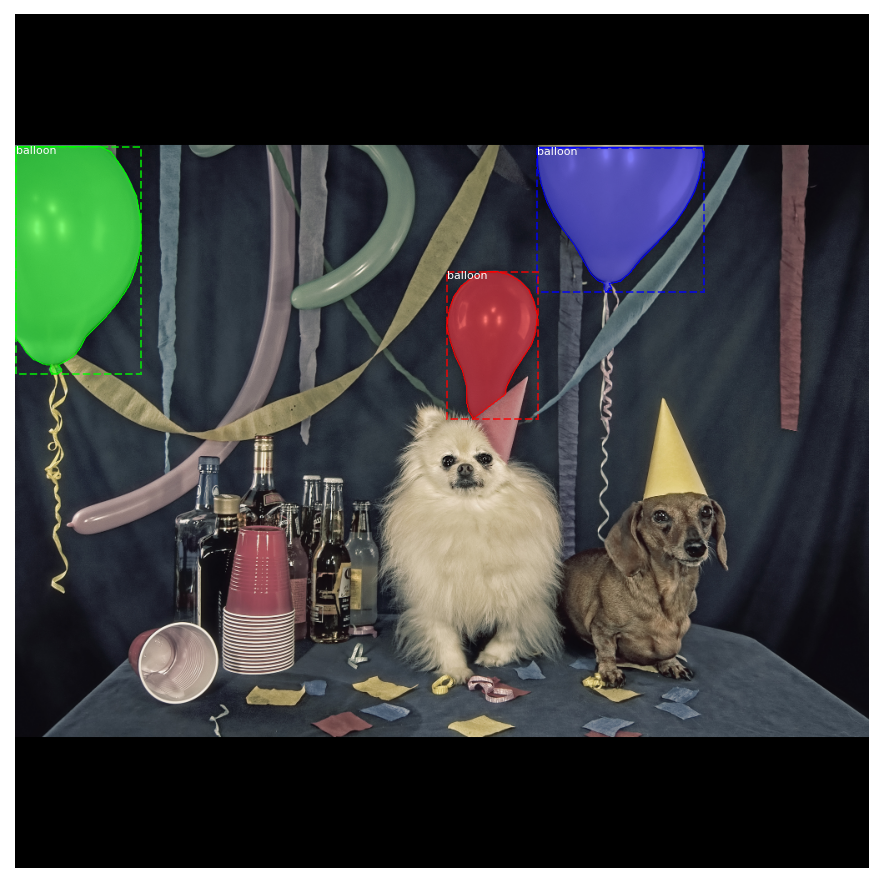

In [7]:
# 加载随机图像和 mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape

# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM,   # 800
    max_dim=config.IMAGE_MAX_DIM,   # 1024
    mode=config.IMAGE_RESIZE_MODE)  # square
mask = utils.resize_mask(mask, scale, padding)
# 计算 Bounding box
bbox = utils.extract_bboxes(mask)

# 显示image和其他统计信息
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# 显示 image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

* 使用高分辨率图像进行训练时，实例二进制掩码可能会变大。例如，如果使用1024x1024图像进行训练，则单个实例的遮罩需要1MB的内存（Numpy使用字节作为布尔值）。 如果一个图像有100个实例，那么仅遮罩即为100MB。

* 为了提高训练速度，我们通过以下方法优化mask：我们存储对象边界框内的mask像素，而不是完整图像的mask。与图像尺寸相比，大多数对象较小，因此我们通过在对象周围不存储很多零来节省空间。

* 我们将mask调整为较小的尺寸（例如56x56或28x28）。对于大于所选尺寸的物体，我们会失去一些准确性。但是大多数对象注释一开始都不是很准确，因此对于大多数实际目的而言，这种损失可以忽略不计。 mini_mask的大小可以在config类中设置。

* 为了可视化掩码调整大小的效果，并验证代码的正确性，我们可视化了一些示例。

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  494.00000  max:  836.00000  int32
mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


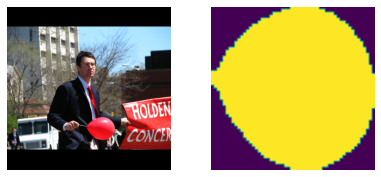

In [8]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [11]:
# visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


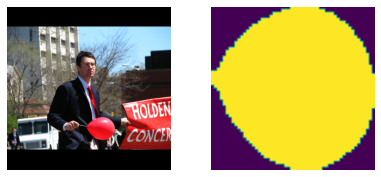

In [10]:
# 使用mini-mask进行尺寸变换.(1024 x 1024 --> 56 x 56)
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

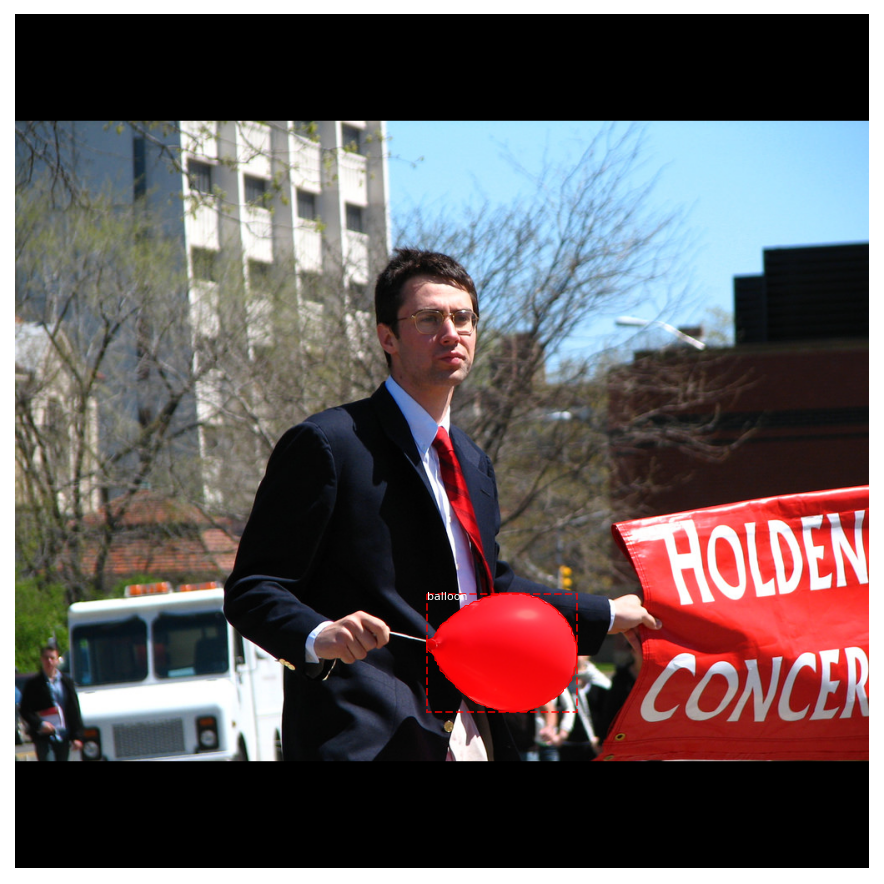

In [11]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

**锚点的顺序很重要** :在训练和预测阶段使用相同的顺序，并且它必须匹配卷积执行的顺序。对于FPN网络，必须对锚进行排序，以使其易于将锚与预测锚得分和移动的卷积层的输出进行匹配。
* 首先按金字塔等级排序。第一层的所有锚点，然后第二层的所有锚点，依此类推。这样可以更轻松地按级别分离锚点。
* 在每个级别内，按特征图处理顺序对锚点进行排序。通常卷积层处理从左上角开始并逐行右移的特征图。
* 对于每个要素地图像元，请为不同比例的锚点选择任何排序顺序。在这里，我们匹配传递给函数的比率的顺序。

**锚步幅：**
* 在FPN体系结构中，前几层的要素图是高分辨率的。例如，如果输入图像为1024x1024，则第一层的特征量为256x256，这将生成约200K锚点（256*256*3）。这些锚点为32x32像素，相对于图像像素的跨度为4像素，因此存在很多重叠。如果我们为特征图中的每个其他像元生成锚点，则可以显着降低负载。例如，跨度为2时，锚点数将减少4。


**在此实现中，我们使用的锚跨距为2，这与paper不同。**

In [12]:
# 生成 Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# 打印 anchors 摘要
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


#### 在特定level的feature map中心可视化一个cell的锚点。

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


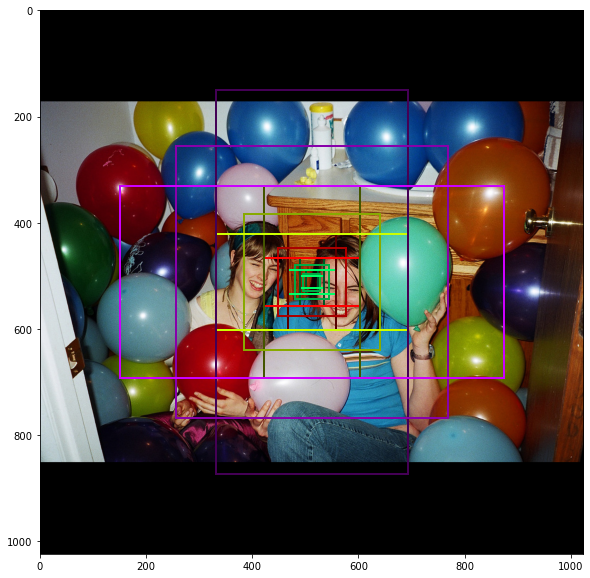

In [13]:
## 在特定level的feature map中心可视化一个cell的锚点

# 加载并绘制随机 image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # 计算图像中心的锚点索引
    level_start = sum(anchors_per_level[:level]) # 先前锚点 levels的总和
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # 绘制锚点. 使用亮度显示阵列中的顺序，从暗到亮。
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [17]:
# 创建 data generator
random_rois = 2000
g = modellib.DataGenerator(
    dataset, config, shuffle=True, random_rois=random_rois,
    detection_targets=True)

In [15]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [18]:
# 获取下一张图片
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = g[0]
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = g[0]
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# 删除mrcnn_class_ids中的最后一维。 仅为了满足Keras对目标形状的限制而添加.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (1, 200, 4)           min:    2.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (1, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (1, 200, 2, 4)        min:   -3.34677  max:    3.02083  float32
mrcnn_mask               shape: (1, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (1, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (1, 100, 4)           min:    0.00000  max:  952.00000  int32
gt_masks                 shape: (1, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (1, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (1, 256, 4)           min:   -2.72322  max:    2.07262  float64
image_id:  4 E:\Mask_RCNN-tf2\samples/balloon\train\17178818589_16e58fc1e5_k.jpg


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (23, 4)               min:  106.00000  max:  951.99994  float32
Positive anchors: 23
Negative anchors: 233
Neutral anchors: 261632
BG                     : 134
balloon                : 66


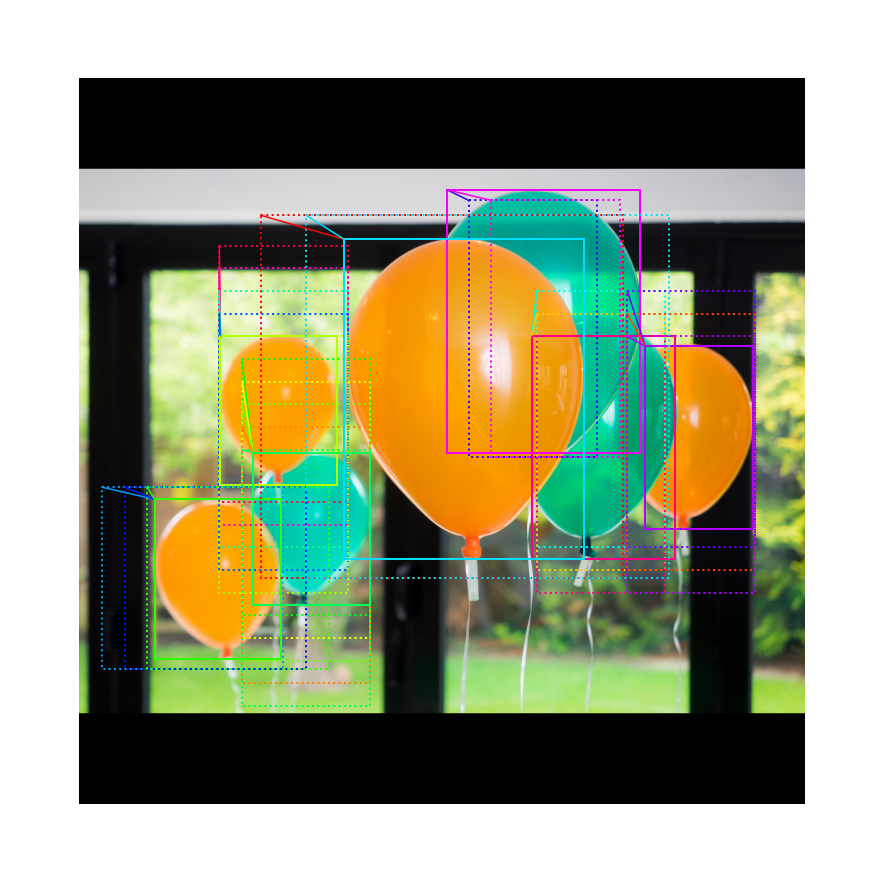

In [19]:
b = 0

# 恢复原始图像（反向归一化）
sample_image = modellib.unmold_image(normalized_images[b], config)

# 计算 anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# 获取 positive anchors 列表
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
# 获取 negative anchors 列表
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
# 获取 neutral anchors 列表
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# 按类别细分 ROI 
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# 展示 positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

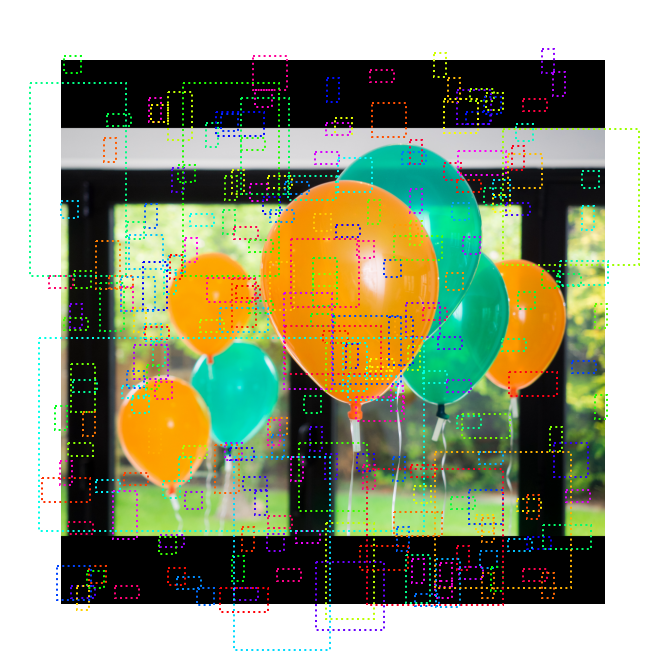

In [20]:
# 展示 negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

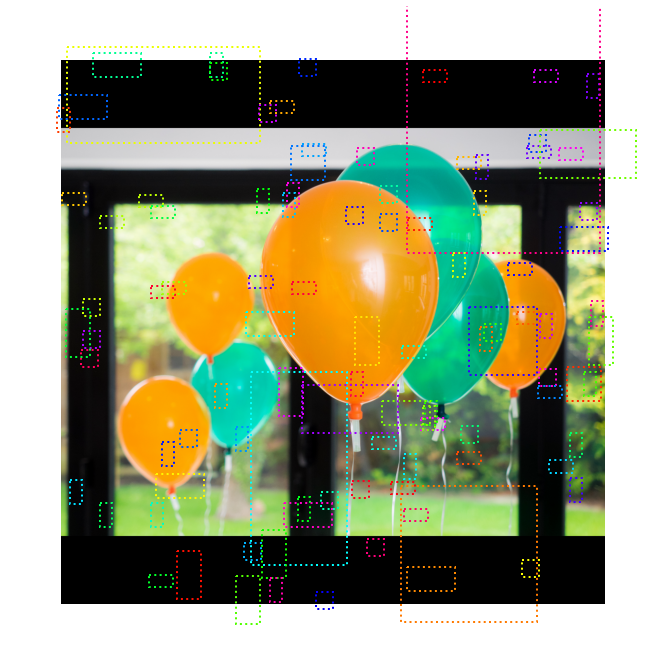

In [21]:
# 展示 neutral anchors. 对训练没什么帮助.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  66
Negative ROIs:  134
Positive Ratio: 0.33
Unique ROIs: 200 out of 200


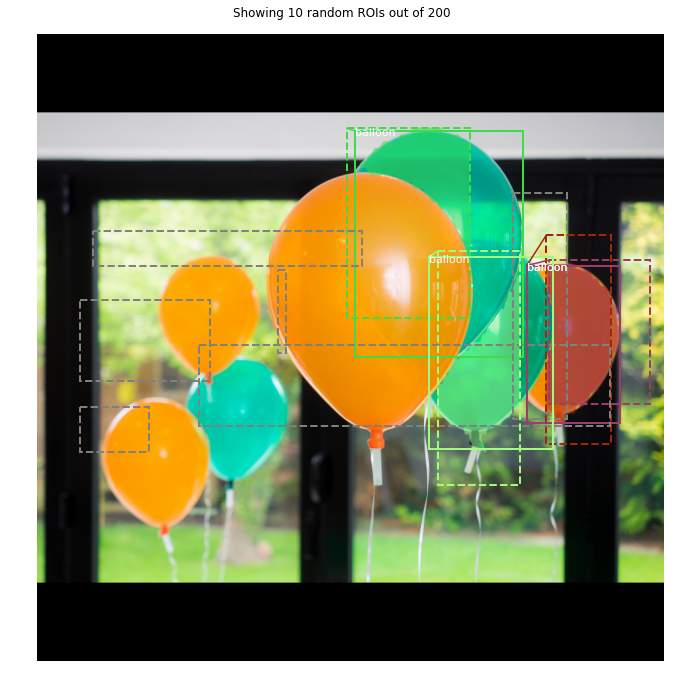

In [27]:
if random_rois:
    # bboxes的分类
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # 调整 ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # masks 的分类
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # 是否有重复的 ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

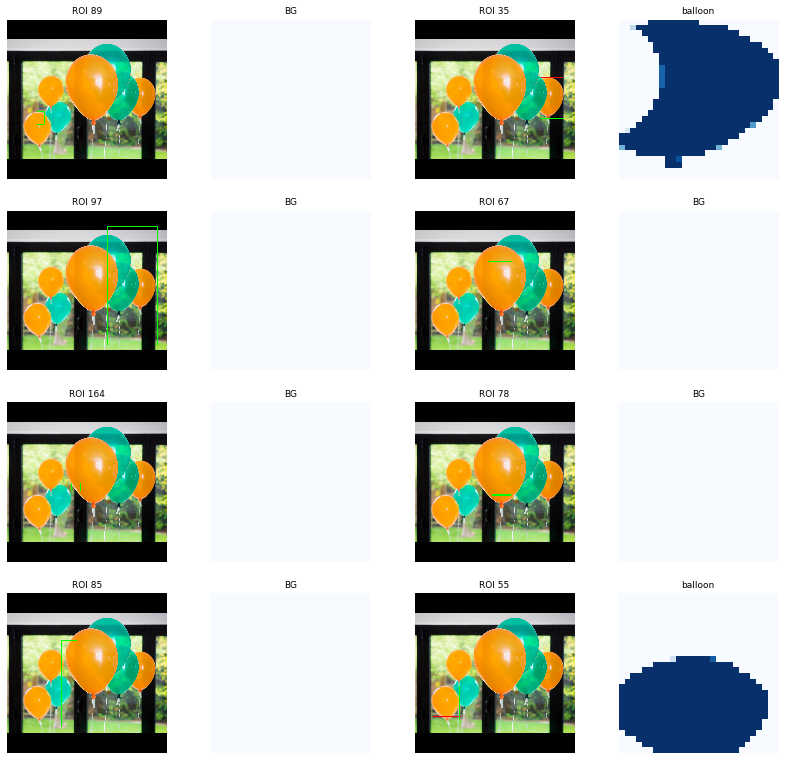

In [40]:
if random_rois:
    # 显示ROIs 以及相应的mask和 bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [39]:
# 检查一组图像中 positive ROIs 的占比
if random_rois:
    limit = 10
    temp_g = modellib.DataGenerator(
        dataset, config, shuffle=True, random_rois=10000, 
        detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = temp_g[0]
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33
